In [ ]:
#This notebook is best run in Google Colab
import pandas as pd
import requests

In [ ]:
#Mounting Google Drive to Open and Save files
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


[Contains information from [Resale Flat Prices] accessed on [30th September 2021] from [https://data.gov.sg/dataset/resale-flat-prices] which is made available under the terms of the Singapore Open Data Licence version 1.0 [https://data.gov.sg/open-data-licence]]


In [ ]:
#Using requests library to get data from data.gov.sg
#Visit the following for API details: https://data.gov.sg/dataset/ckan-datastore-search?resource_id=6a7db56a-4df7-4228-8d57-37ded1b09306
#Searching for data in years 2021
dataset_id = 'f1765b54-a209-4718-8d38-a39237f502b3'
result_limit = '999999' #tweak the limit to your liking
filter = '{"month":"2021"}' #the filter needs to be in dictionary form
req = requests.get('https://data.gov.sg/api/action/datastore_search?resource_id='+dataset_id+'&limit='+result_limit+'&q='+filter, headers={'User-Agent': 'Mozilla/5.0'})
data_json = req.json()

In [ ]:
#displaying the last record retrieved in JSON format
data_json['result']['records'][len(data_json['result']['records'])-1]

{'_full_count': '43920',
 '_id': 219099,
 'block': '511B',
 'flat_model': 'Improved',
 'flat_type': '5 ROOM',
 'floor_area_sqm': '113',
 'lease_commence_date': '2017',
 'month': '2021-10',
 'rank month': 0.0573088,
 'remaining_lease': '94 years 11 months',
 'resale_price': '612000',
 'storey_range': '07 TO 09',
 'street_name': 'YISHUN ST 51',
 'town': 'YISHUN'}

In [ ]:
#converting JSON data into a Pandas data frame
df_final = pd.DataFrame(data_json['result']['records'])
print(df_final.head())
print(len(df_final))

         town flat_type _full_count  ... storey_range     _id block
0  ANG MO KIO    2 ROOM       43920  ...     07 TO 09  174187   170
1  ANG MO KIO    2 ROOM       43920  ...     01 TO 03  174189   170
2  ANG MO KIO    3 ROOM       43920  ...     04 TO 06  174191   216
3  ANG MO KIO    3 ROOM       43920  ...     07 TO 09  174193   223
4  ANG MO KIO    3 ROOM       43920  ...     10 TO 12  174195   223

[5 rows x 14 columns]
43920


In [ ]:
#Removing periods in the address strings that cause the onemap API to not return correct results
df_final['street_name'] = df_final['street_name'].str.replace(".","", n=-1)

In [ ]:
#All values should return -1 to indicate "ST. GEORGE'S LANE is not found"
df_final['street_name'].str.find("ST. GEORGE'S").describe()

count    43920.0
mean        -1.0
std          0.0
min         -1.0
25%         -1.0
50%         -1.0
75%         -1.0
max         -1.0
Name: street_name, dtype: float64

In [ ]:
#creating a new dataframe column 'address' from 'block' and 'street_name' columns
df_final['address'] = df_final['block'] + ' ' + df_final['street_name']

In [ ]:
df_final.head()

,town,flat_type,_full_count,flat_model,floor_area_sqm,street_name,resale_price,rank month,month,remaining_lease,lease_commence_date,storey_range,_id,block,address
0,ANG MO KIO,2 ROOM,43920,Improved,45,ANG MO KIO AVE 4,225000,0.057309,2021-01,64 years 01 month,1986,07 TO 09,174187,170,170 ANG MO KIO AVE 4
1,ANG MO KIO,2 ROOM,43920,Improved,45,ANG MO KIO AVE 4,211000,0.057309,2021-01,64 years 01 month,1986,01 TO 03,174189,170,170 ANG MO KIO AVE 4
2,ANG MO KIO,3 ROOM,43920,New Generation,73,ANG MO KIO AVE 1,275888,0.057309,2021-01,54 years 04 months,1976,04 TO 06,174191,216,216 ANG MO KIO AVE 1
3,ANG MO KIO,3 ROOM,43920,New Generation,67,ANG MO KIO AVE 1,316800,0.057309,2021-01,56 years 01 month,1978,07 TO 09,174193,223,223 ANG MO KIO AVE 1
4,ANG MO KIO,3 ROOM,43920,New Generation,67,ANG MO KIO AVE 1,305000,0.057309,2021-01,56 years,1978,10 TO 12,174195,223,223 ANG MO KIO AVE 1


In [ ]:
#removing unnecessary columns
df_final = df_final.drop(['rank month','_full_count'], axis=1)

[Contains information from [Planning Area Polygons, Reverse Geocode] accessed on [5 October 2021] from [https://www.onemap.gov.sg/docs/#planning-area] which is made available under the terms of the Singapore Open Data Licence version 1.0 [https://www.onemap.gov.sg/legal/opendatalicence.html]]

In [ ]:
#Getting latitude and longitude data from the onemap API. 
#Code referenced from here: https://towardsdatascience.com/geocoding-singapore-coordinates-onemap-api-3e1542bf26f7
def getcoordinates(address):
    req = requests.get('https://developers.onemap.sg/commonapi/search?searchVal='+address+'&returnGeom=Y&getAddrDetails=Y&pageNum=1', headers={'User-Agent': 'Mozilla/5.0'})
    resultsdict = eval(req.text)
    if len(resultsdict['results'])>0:
        return resultsdict['results'][0]['LATITUDE'], resultsdict['results'][0]['LONGITUDE']
    else:
        pass

In [ ]:
#This code block takes a very long time to run. It took more than 8 hours for 20000+ addresses.
coordinateslist= []
count = 0
failed_count = 0
for address in df_final['address']:
    try:
        if len(getcoordinates(address))>0:
            count = count + 1
            print('Extracting',count,'out of',len(df_final['address']),'addresses',address,getcoordinates(address))
            coordinateslist.append(getcoordinates(address))
    except:
        count = count + 1           
        failed_count = failed_count + 1
        print('Failed to extract',count,'out of',len(df_final['address']),'addresses',address)
        coordinateslist.append(None)
print('Total Number of Addresses With No Coordinates',failed_count)

In [ ]:
#combining the resale flat data frame with the cooridinates data frame
df_coordinates = pd.DataFrame(coordinateslist)
df_combined = df_final.join(df_coordinates)
df_combined = df_combined.rename(columns={0:'Latitude', 1:'Longitude'})

In [ ]:
df_combined

In [ ]:
#Saving the data frame to Google Drive (Optional)
df_combined.to_csv('/drive/My Drive/Python Practice/HDB Resale Details 2021.csv')

In [ ]:
#Loading the data frame from Google Drive (Optional)
df_combined = pd.read_csv('/drive/My Drive/Python Practice/HDB Resale Details 2021.csv')

In [ ]:
#installing and importing libraries to process MRT shape file
!pip install geopandas
import geopandas
import matplotlib.pyplot as plt
from geopy import distance
%matplotlib inline

     |████████████████████████████████| 1.0 MB 5.3 MB/s 
     |████████████████████████████████| 15.4 MB 39 kB/s 
     |████████████████████████████████| 6.3 MB 49.3 MB/s 


[Contains information from [Train Station] Dataset accessed on [30th September 2021] from [https://datamall.lta.gov.sg/content/datamall/en/search_datasets.html?searchText=mrt] which is made available under the terms of the Singapore Open Data Licence version 1.0 [https://datamall.lta.gov.sg/content/datamall/en/SingaporeOpenDataLicence.html]]

In [ ]:
#MRT information downloaded from https://datamall.lta.gov.sg/content/dam/datamall/datasets/Geospatial/TrainStation.zip and placed in Google Drive
#opening and loading the shapefile using geopandas library

zipfile = "/drive/My Drive/Python Practice/TrainStation.zip!TrainStation_Aug2021/MRTLRTStnPtt.shp"
gdf_mrt = geopandas.read_file(zipfile)

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
#Checking the Coordinate Reference System(CRS). Singapore uses the "SVY21" cartesian(flat earth) projection . See https://epsg.io/3414
gdf_mrt.crs

<Projected CRS: PROJCS["SVY21",GEOGCS["SVY21[WGS84]",DATUM["WGS_19 ...>
Name: SVY21
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
gdf_mrt.head()

,OBJECTID,STN_NAME,STN_NO,geometry
0,1,EUNOS MRT STATION,EW7,POINT (35782.955 33560.078)
1,2,CHINESE GARDEN MRT STATION,EW25,POINT (16790.747 36056.302)
2,3,KHATIB MRT STATION,NS14,POINT (27962.311 44352.568)
3,4,KRANJI MRT STATION,NS7,POINT (20081.697 45214.548)
4,5,REDHILL MRT STATION,EW18,POINT (26163.478 30218.820)


In [ ]:
#Converting currect CRS to EPSG.4326 (elipsoid projection) i.e. GPS Coordinate System to obtain coordinates in decimal degrees. See https://epsg.io/4326
gdf_mrt = gdf_mrt.to_crs("EPSG:4326")

In [ ]:
#Coordinates are now in GPS format but the latitude and longitude are reversed.
gdf_mrt.head()

,OBJECTID,STN_NAME,STN_NO,geometry
0,1,EUNOS MRT STATION,EW7,POINT (103.90325 1.31978)
1,2,CHINESE GARDEN MRT STATION,EW25,POINT (103.73260 1.34235)
2,3,KHATIB MRT STATION,NS14,POINT (103.83298 1.41738)
3,4,KRANJI MRT STATION,NS7,POINT (103.76217 1.42518)
4,5,REDHILL MRT STATION,EW18,POINT (103.81682 1.28956)


In [ ]:
#extracting coordinates into seperate columns
gdf_mrt['Latitude'] = gdf_mrt.geometry.apply(lambda p: p.y)
gdf_mrt['Longitude'] = gdf_mrt.geometry.apply(lambda p: p.x)

In [ ]:
gdf_mrt.head()

,OBJECTID,STN_NAME,STN_NO,geometry,Latitude,Longitude
0,1,EUNOS MRT STATION,EW7,POINT (103.90325 1.31978),1.319779,103.903252
1,2,CHINESE GARDEN MRT STATION,EW25,POINT (103.73260 1.34235),1.342353,103.732597
2,3,KHATIB MRT STATION,NS14,POINT (103.83298 1.41738),1.417383,103.832980
3,4,KRANJI MRT STATION,NS7,POINT (103.76217 1.42518),1.425178,103.762165
4,5,REDHILL MRT STATION,EW18,POINT (103.81682 1.28956),1.289563,103.816817


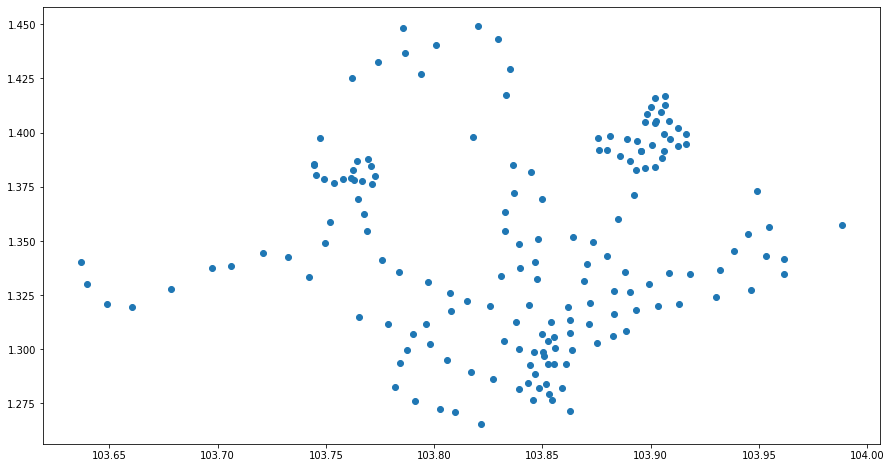

In [ ]:
#Plotting MRT&LRT station locations
fig,ax = plt.subplots(figsize = (15,15))
gdf_mrt.plot(ax=ax)

In [ ]:
#Saving to Google Drive
gdf_mrt.to_csv('/drive/My Drive/Python Practice/MRT Stations.csv')

In [ ]:
#Creating lists of the closest station and the corresponding distance for each address
distance_list = []
closest_station_list = []

for row in range(0, len(df_combined)):
  shortest_distance = 0
  closest_station = ''
  pnt_flat= (df_combined['Latitude'][row], df_combined['Longitude'][row])
  
  for stn in range(0, len(gdf_mrt)):
    pnt_stn = (gdf_mrt['Latitude'][stn],gdf_mrt['Longitude'][stn])
    dist = distance.distance(pnt_flat, pnt_stn).m
        
    if shortest_distance == 0:
      shortest_distance = dist
      closest_station = gdf_mrt['STN_NAME'][stn]
    elif dist < shortest_distance:
      shortest_distance = dist
      closest_station = gdf_mrt['STN_NAME'][stn]
    else:
      pass
    #print(row, stn, dist, shortest_distance, closest_station)
  
  print("Record:{} {} is {:.0f}m away from closest station, {}".format(row, df_combined['address'][row],shortest_distance, closest_station))
  
  distance_list.append(shortest_distance)
  closest_station_list.append(closest_station)

Streaming output truncated to the last 5000 lines.
Record:16496 807B CHAI CHEE RD is 843m away from closest station, BEDOK MRT STATION
Record:16497 808C CHAI CHEE RD is 806m away from closest station, BEDOK MRT STATION
Record:16498 807C CHAI CHEE RD is 871m away from closest station, BEDOK MRT STATION
Record:16499 20 CHAI CHEE RD is 830m away from closest station, BEDOK MRT STATION
Record:16500 807C CHAI CHEE RD is 871m away from closest station, BEDOK MRT STATION
Record:16501 808C CHAI CHEE RD is 806m away from closest station, BEDOK MRT STATION
Record:16502 807A CHAI CHEE RD is 830m away from closest station, BEDOK MRT STATION
Record:16503 54 CHAI CHEE ST is 678m away from closest station, BEDOK NORTH MRT STATION
Record:16504 50 CHAI CHEE ST is 778m away from closest station, BEDOK NORTH MRT STATION
Record:16505 42 CHAI CHEE ST is 642m away from closest station, BEDOK MRT STATION
Record:16506 42 CHAI CHEE ST is 642m away from closest station, BEDOK MRT STATION
Record:16507 50 CHAI CH

In [ ]:
#Converting lists to data frames
df_closest_station = pd.DataFrame(closest_station_list, columns=['Nearest Station'])
df_distance = pd.DataFrame(distance_list, columns=['Station Distance'])

In [ ]:
#Merging nearest station and station distance data frames with the resale flat dataframe
df_complete = df_combined.join([df_closest_station, df_distance])

In [ ]:
df_complete.head()

,Unnamed: 0,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,remaining_lease,lease_commence_date,storey_range,_id,block,address,Latitude,Longitude,Nearest Station,Station Distance
0,0,ANG MO KIO,2 ROOM,Improved,45.0,ANG MO KIO AVE 4,225000.0,2021-01,64 years 01 month,1986,07 TO 09,83591,170,170 ANG MO KIO AVE 4,1.374001,103.836431,MAYFLOWER MRT STATION,216.108040
1,1,ANG MO KIO,2 ROOM,Improved,45.0,ANG MO KIO AVE 4,211000.0,2021-01,64 years 01 month,1986,01 TO 03,83592,170,170 ANG MO KIO AVE 4,1.374001,103.836431,MAYFLOWER MRT STATION,216.108040
2,2,ANG MO KIO,3 ROOM,New Generation,73.0,ANG MO KIO AVE 1,275888.0,2021-01,54 years 04 months,1976,04 TO 06,83593,216,216 ANG MO KIO AVE 1,1.366197,103.841505,MAYFLOWER MRT STATION,833.988794
3,3,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 1,316800.0,2021-01,56 years 01 month,1978,07 TO 09,83594,223,223 ANG MO KIO AVE 1,1.366048,103.838123,BRIGHT HILL MRT STATION,651.904319
4,4,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 1,305000.0,2021-01,56 years,1978,10 TO 12,83595,223,223 ANG MO KIO AVE 1,1.366048,103.838123,BRIGHT HILL MRT STATION,651.904319


In [ ]:
#Saving to Google Drive
df_complete.to_csv('/drive/My Drive/Python Practice/HDB Resale Details with MRT information.csv')